## Vanilla autoencoders

The Vanilla autoencoder consists of one hidden layer only. The number of neurons in the hidden layer are less than the number of neurons in the input (or output) layer.

### TensorFlow Keras Layers - defining custom layers

We can make our own layer by simply making it a child class of the Layers class. It is necessary to define the dimensions of the output while defining the layer. Though input dimensions are optional, if you do not define them, it will infer it automatically from the data. To build our own layer we will need to implement three methods:
<ul><li>__init__() : Here, you define all input-independent initializations
    <li>build() : Here, we define the shapes of input tensors and can perform rest initializations if required.
    <li>call() : THis is where the forward computation is performed.
</ul>   

In [1]:
# create an Encoder class.
import tensorflow as tf
import tensorflow.keras as K

class Encoder(K.layers.Layer):
    def __init__(self, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_layer = K.layers.Dense(units=hidden_dim, activation=tf.nn.relu)
    
    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return activation

In [2]:
# define the Decoder class.
# this class takes in the output from the Encoder and then passes it through a fully connected neural network.
class Decoder(K.layers.Layer):
    def __init__(self, hidden_dim, original_dim):
        super(Decoder, self).__init__()
        self.output_layer = K.layers.Dense(units=original_dim, activation=tf.nn.relu)

    def call(self, encoded):
        activation = self.output_layer(encoded)
        return activation

In [3]:
# build to autoencoder model using tensorflkw.keras.Model object
class Autoencoder(K.Model):
    def __init__(self, hidden_dim, original_dim):
        super(Autoencoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(hidden_dim=hidden_dim)
        self.decoder = Decoder(hidden_dim=hidden_dim, original_dim = original_dim)
        
    # define the signal flow
    def call(self, input_features):
        encoded = self.encoder(input_features)
        reconstructed = self.decoder(encoded)
        return reconstructed

### Reconstructing handwritten digits using an autoencoder

In [5]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt

In [6]:
# define some Hyperparameters
np.random.seed(11)
tf.random.set_seed(11)
batch_size = 256
max_epochs = 50
learning_rate = 1e-3
momentum = 8e-1
hidden_dim = 128
original_dim = 784

In [7]:
# we are not using one-hot encoded labels; this is the case because we are not using labels to train the network.
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()
x_train = x_train / 255.
x_test = x_test / 255.
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test, (x_test.shape[0], 784))
# employ the from_tensor_slices to generate slices of tensors
training_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)

In [8]:
# define the loss and optimizers to be used for training.
autoencoder = Autoencoder(hidden_dim=hidden_dim, original_dim=original_dim)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

def loss(preds, real):
    return tf.reduce_mean(tf.square(tf.subtract(preds, real)))

In [9]:
# Instead of using the auto-training loop, we will define a custom training.
# We use tf.GradientTape to record the gradients as they are calculated and implicitly apply the gradients to all the trainable variables of our model
def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        preds = model(original)
        reconstruction_error = loss(preds, original)
        gradients = tape.gradient(reconstruction_error, model.trainable_variables)
        gradient_variables = zip(gradients, model.trainable_variables)
        opt.apply_gradients(gradient_variables)
    
    return reconstruction_error

In [10]:
# The preceding train() function will be invoked in a training loop, with the dataset fed to the model in batches
def train_loop(model, opt, loss, dataset, epochs=20):
    for epoch in range(epochs):
        
        epoch_loss = 0
        
        for step, batch_features in enumerate(dataset):
            loss_values = train(loss, model, opt, batch_features)
            epoch_loss += loss_values
        
        model.loss.append(epoch_loss)
        print('Epoch {}/P{}. Loss: {}'.format(epoch+1, epochs, epoch_loss.numpy()))

In [11]:
# train our autoencoder
train_loop(autoencoder, opt, loss, training_dataset, epochs=max_epochs)

Epoch 1/P50. Loss: 5.150146961212158
Epoch 2/P50. Loss: 3.076070785522461
Epoch 3/P50. Loss: 2.9740633964538574
Epoch 4/P50. Loss: 2.887542724609375
Epoch 5/P50. Loss: 2.8968920707702637
Epoch 6/P50. Loss: 2.836301326751709
Epoch 7/P50. Loss: 2.823406934738159
Epoch 8/P50. Loss: 2.8302717208862305
Epoch 9/P50. Loss: 2.8086085319519043
Epoch 10/P50. Loss: 2.796436071395874
Epoch 11/P50. Loss: 2.8078413009643555
Epoch 12/P50. Loss: 2.8039464950561523
Epoch 13/P50. Loss: 2.792804002761841
Epoch 14/P50. Loss: 2.803535223007202
Epoch 15/P50. Loss: 2.823622226715088
Epoch 16/P50. Loss: 2.7801482677459717
Epoch 17/P50. Loss: 2.7976064682006836
Epoch 18/P50. Loss: 2.781986713409424
Epoch 19/P50. Loss: 2.8045694828033447
Epoch 20/P50. Loss: 2.7752535343170166
Epoch 21/P50. Loss: 2.762800455093384
Epoch 22/P50. Loss: 2.798692226409912
Epoch 23/P50. Loss: 2.780217170715332
Epoch 24/P50. Loss: 2.762648820877075
Epoch 25/P50. Loss: 2.7534499168395996
Epoch 26/P50. Loss: 2.765437602996826
Epoch 27/P

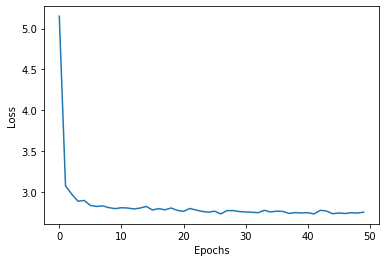

In [12]:
plt.plot(range(max_epochs), autoencoder.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

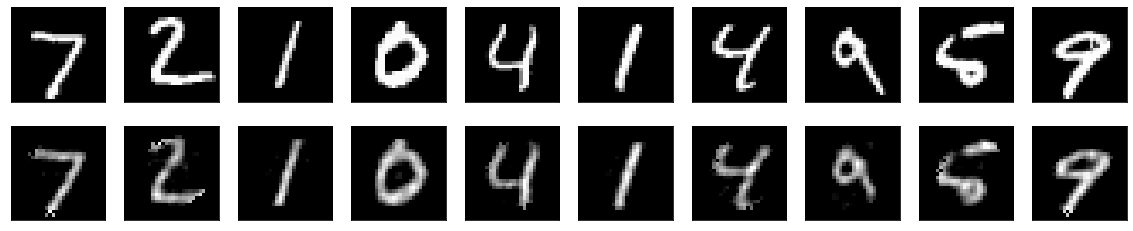

In [14]:
# you can see the original(top) and reconstructed(bottom) images
number = 10 # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(autoencoder(x_test)[index].numpy().reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

This should give you an idea of the power of the autoencoder for dimensionality reduction. One advantage of autoencoders over PCA for dimensionality reduction is that while PCA can only represent linear transformations, we can use non-linear activation functions in autoencoders.

 ## Sparse autoencoder

In sparse autoencoders, a sparse penalty term is added to the reconstruction error. This tries to ensure that fewer units in the bottleneck layer will fire at any given time. 

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

In [2]:
# define some Hyperparameters
np.random.seed(11)
tf.random.set_seed(11)
batch_size = 256
max_epochs = 50
learning_rate = 1e-3
momentum = 8e-1
hidden_dim = 128
original_dim = 784

In [3]:
# we are not using one-hot encoded labels; this is the case because we are not using labels to train the network.
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()
x_train = x_train / 255.
x_test = x_test / 255.
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test, (x_test.shape[0], 784))
# employ the from_tensor_slices to generate slices of tensors
training_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)

you can see that the Dense layer of the Encoder now has an additional parameter, activity_regularizer.
<br>
The activity regularizer tries to reudce the layer output. It will reduce both weights and bias of the fully connected layer to ensure that the output is as small as it can be.
<br>
types of activity_regularizer:
<ul><li>l1 : Here the activity is computed as the sum of absolute values
    <li>l2 : The activity here is calculated as the sum of the squared values
    <li>l1_l2 : This includes both L1 and L2 terms

In [11]:
# create an Encoder class.
class SparseEncoder(K.layers.Layer):
    def __init__(self, hidden_dim):
        super(SparseEncoder, self).__init__()
        self.hidden_layer = K.layers.Dense(units=hidden_dim, 
                                           activation=tf.nn.relu, 
                                           activity_regularizer=regularizers.l1(10e-5))
        
    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return activation

Alternatively, you can explicitly add a regularization term for sparsity in the loss function. To do so you will need to implement the regularization for the sparsity term as a function. you can check the mathematical details in Andrew Ng's lecture here : https://web.stanford.edu/class/cs294a/sparseAutoencoder_2011new.pdf
<br>
One standard way to do this is to use Kullback-Leiber (KL) divergence. (https://www.stat.cmu.edu/~cshalizi/754/2006/notes/lecture-28.pdf)

In [12]:
# define the Decoder class.
class SparseDecoder(K.layers.Layer):
    def __init__(self, hidden_dim, original_dim):
        super(SparseDecoder, self).__init__()
        self.output_layer = K.layers.Dense(units=original_dim, activation=tf.nn.relu)
        
    def call(self, encoded):
        activation = self.output_layer(encoded)
        return activation

In [13]:
# build to autoencoder model using tensorflkw.keras.Model object
class SparseAutoencoder(K.Model):
    def __init__(self, hidden_dim, original_dim):
        super(SparseAutoencoder, self).__init__()
        self.loss = []
        self.encoder = SparseEncoder(hidden_dim=hidden_dim)
        self.decoder = SparseDecoder(hidden_dim=hidden_dim, original_dim=original_dim)
        
    def call(self, input_features):
        encoded = self.encoder(input_features)
        reconstructed = self.decoder(encoded)
        return reconstructed

In [14]:
autoencoder = SparseAutoencoder(hidden_dim=hidden_dim, original_dim=original_dim)
opt = tf.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

def loss(preds, real):
    return tf.reduce_mean(tf.square(tf.subtract(preds, real)))

# Instead of using the auto-training loop, we will define a custom training.
# We use tf.GradientTape to record the gradients as they are calculated and implicitly apply the gradients to all the trainable variables of our model
def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        preds = model(original)
        reconstruction_error = loss(preds, original)
    
    gradients = tape.gradient(reconstruction_error, model.trainable_variables)
    gradient_variables = zip(gradients, model.trainable_variables)
    opt.apply_gradients(gradient_variables)
    
    return reconstruction_error

In [15]:
def train_loop(model, opt, loss, dataset, epochs=20):
    for epoch in range(epochs):
        epoch_loss = 0
        for step, batch_features in enumerate(dataset):
            loss_values = train(loss, model, opt, batch_features)
            epoch_loss += loss_values
        model.loss.append(epoch_loss)
        print('Epoch {}/{}. Loss:{}'.format(epoch+1, epochs, epoch_loss.numpy()))

In [16]:
model = SparseAutoencoder(hidden_dim=hidden_dim, original_dim=original_dim)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

train_loop(model, opt, loss, training_dataset, epochs=max_epochs)

Epoch 1/50. Loss:5.150146484375
Epoch 2/50. Loss:3.0760231018066406
Epoch 3/50. Loss:2.980156898498535
Epoch 4/50. Loss:2.8858799934387207
Epoch 5/50. Loss:2.8585197925567627
Epoch 6/50. Loss:2.855571746826172
Epoch 7/50. Loss:2.8168275356292725
Epoch 8/50. Loss:2.830695152282715
Epoch 9/50. Loss:2.8172266483306885
Epoch 10/50. Loss:2.8357157707214355
Epoch 11/50. Loss:2.804548978805542
Epoch 12/50. Loss:2.812305212020874
Epoch 13/50. Loss:2.800151824951172
Epoch 14/50. Loss:2.7960498332977295
Epoch 15/50. Loss:2.808089256286621
Epoch 16/50. Loss:2.817337989807129
Epoch 17/50. Loss:2.817669153213501
Epoch 18/50. Loss:2.8156356811523438
Epoch 19/50. Loss:2.8165557384490967
Epoch 20/50. Loss:2.8044371604919434
Epoch 21/50. Loss:2.8042140007019043
Epoch 22/50. Loss:2.7992618083953857
Epoch 23/50. Loss:2.8132333755493164
Epoch 24/50. Loss:2.8045427799224854
Epoch 25/50. Loss:2.7994773387908936
Epoch 26/50. Loss:2.8280813694000244
Epoch 27/50. Loss:2.8119845390319824
Epoch 28/50. Loss:2.806

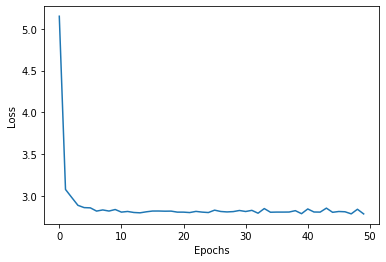

In [17]:
plt.plot(range(max_epochs), model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

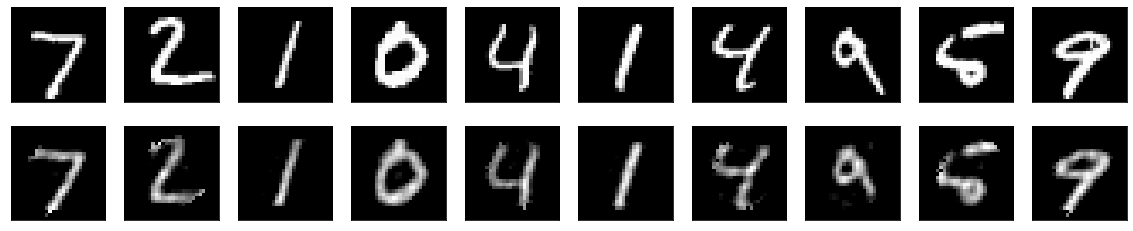

In [18]:
# you can see the original(top) and reconstructed(bottom) images
number = 10 # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(x_test)[index].numpy().reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Denoising autoencoders

A denoising autoencoder learns from a corrupted (noisy) input; it feed its encoder network the nosiy input, and then the reconstructed image from the decoder is compared with the original input. The idea is that his will help the network learn how to denoise an input.
<br>
A Denoising autoencoder has two main differences from other autoencoder: first, n_hidden, the number of hidden units in the bottleneck layer is greater than the number of units in the input layer. Second, the input to the eocnder is corrupted input. To do this we add a noise term in both test and training imges:

In [ ]:
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

### Clearing images using a Denoising autoencoder

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt

In [2]:
# define some Hyperparameters
np.random.seed(11)
tf.random.set_seed(11)
batch_size = 256
max_epochs = 50
learning_rate = 1e-3
momentum = 8e-1
hidden_dim = 128
original_dim = 784

In [3]:
# we are not using one-hot encoded labels; this is the case because we are not using labels to train the network.
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()
x_train = x_train / 255.
x_test = x_test / 255.
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test, (x_test.shape[0], 784))

# Generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.5
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

In [4]:
# We use the same encoder, decoder, and autoencoder classes as defined in the Vanilla autoencoders section

# Encoder
class Encoder(K.layers.Layer):
    def __init__(self, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_layer = K.layers.Dense(units=hidden_dim, activation=tf.nn.relu)
    
    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return activation

# Decoder
class Decoder(K.layers.Layer):
    def __init__(self, hidden_dim, original_dim):
        super(Decoder, self).__init__()
        self.output_layer = K.layers.Dense(units=original_dim, activation=tf.nn.relu)

    def call(self, encoded):
        activation = self.output_layer(encoded)
        return activation
    
# build to autoencoder model using tensorflkw.keras.Model object
class Autoencoder(K.Model):
    def __init__(self, hidden_dim, original_dim):
        super(Autoencoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(hidden_dim=hidden_dim)
        self.decoder = Decoder(hidden_dim=hidden_dim, original_dim = original_dim)
        
    # define the signal flow
    def call(self, input_features):
        encoded = self.encoder(input_features)
        reconstructed = self.decoder(encoded)
        return reconstructed

In [5]:
# create the model and define the loss and optimizers
# we are using the easier keras inbuilt compile() and fit() methods:
model = Autoencoder(hidden_dim=hidden_dim, original_dim=original_dim)

model.compile(loss='mse', optimizer='adam')
loss = model.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test),
                epochs=max_epochs, batch_size=batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 26us/sample - loss: 0.0530 - val_loss: 0.0352
Epoch 2/50
60000/60000 [==============================] - 1s 12us/sample - loss: 0.0317 - val_loss: 0.0288
Epoch 3/50
60000/60000 [==============================] - 1s 12us/sample - loss: 0.0283 - val_loss: 0.0274
Epoch 4/50
60000/60000 [==============================] - 1s 12us/sample - loss: 0.0275 - val_loss: 0.0269
Epoch 5/50
60000/60000 [==============================] - 1s 12us/sample - loss: 0.0271 - val_loss: 0.0266
Epoch 6/50
60000/60000 [==============================] - 1s 12us/sample - loss: 0.0270 - val_loss: 0.0267
Epoch 7/50
60000/60000 [==============================] - 1s 12us/sample - loss: 0.0269 - val_loss: 0.0265
Epoch 8/50
60000/60000 [==============================] - 1s 12us/sample - loss: 0.0269 - val_loss: 0.0264
Epoch 9/50
60000/60000 [==============================] - 1s 12us/sample - loss: 0.0266 - val_

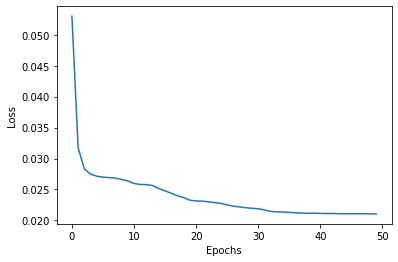

In [6]:
# plot the training loss
plt.plot(range(max_epochs), loss.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



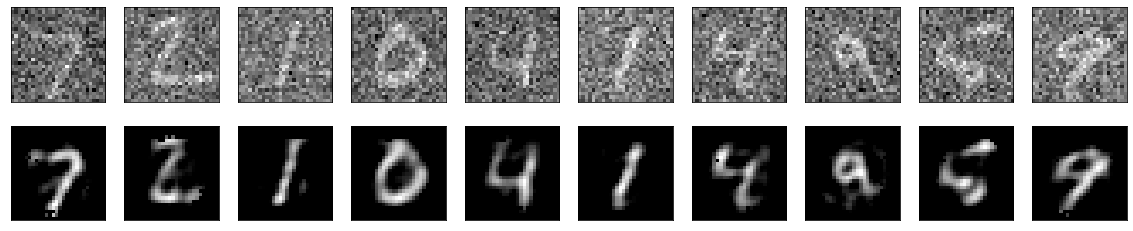

In [9]:
# you can see the original(top) and reconstructed(bottom) images
number = 10 # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test_noisy[index].reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(x_test_noisy)[index].numpy().reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Stacked autoencoder

We can build Deep autoencoders by stacking many layers of both encoder and decoder; such an autoencoder is called a Stacked autoencoder. The stacked autoencoder can be trained as a whole network with an aim to minimize the reconstruction error. Or each individual encoder/decoder network can first be pretrained using the unsupervised method you learned earlier, and then the complete network can be fine-tuned. When the deep autoencoder network is a convolutional network, we call it a Convolutional Autoencoder.

### Convolutional autoencoder for removing noise from images

We will make stacks of convolutional layers (along with maxpooling or upsample layers). We will also be training the entire autoencoder as a single entity.

1. We import all the required modules

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D

2. We specify our hyperparameters.

In [4]:
np.random.seed(11)
tf.random.set_seed(11)
batch_size = 128
max_epochs = 50
filters = [32, 32, 16]

3. We read the data and preprocess it.

In [5]:
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()
x_train = x_train / 255.
x_test = x_test / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise = 0.5
x_train_noisy = x_train + noise * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_test_noisy = np.clip(x_test_noisy, 0, 1)
x_train_noisy = x_train_noisy.astype('float32')
x_test_noisy = x_test_noisy.astype('float32')

print(x_test_noisy[1].dtype)

float32


4. Let us now define out encoder. The encoder consists of three convolutional layers, each followed by a max pooling layer. The output image is of size 4 x 4 and the last convolutional layer has 16 filters, the image has 16 channels

In [10]:
class Encoder(K.layers.Layer):
    def __init__(self, filters):
        super(Encoder, self).__init__()
        self.conv1 = Conv2D(filters=filters[0], kernel_size=3, strides=1,
                            activation='relu', padding='same')
        self.conv2 = Conv2D(filters=filters[1], kernel_size=3, strides=1,
                            activation='relu', padding='same')
        self.conv3 = Conv2D(filters=filters[2], kernel_size=3, strides=1,
                            activation='relu', padding='same')
        self.pool = MaxPooling2D((2, 2), padding='same')
        
    def call(self, input_features):
        x = self.conv1(input_features)
        print('Ex1', x.shape)
        x = self.pool(x)
        print('Ex2', x.shape)
        x = self.conv2(x)
        print('Ex3', x.shape)
        x = self.pool(x)
        print('Ex4', x.shape)
        x = self.conv3(x)
        print('Ex5', x.shape)
        x = self.pool(x)
        print('Ex6', x.shape)
        return x

5. Next comes the decoder. It is the exact opposite of the eocnder in design, and instead of max pooling we are using upsampling to increase the size back.
<br>
Notice both encoder and decoder are still classes based on the TensorFlow Keras Layers class, but now they have multiple layers inside them.

In [11]:
class Decoder(K.layers.Layer):
    def __init__(self, filters):
        super(Decoder, self).__init__()
        self.conv1 = Conv2D(filters=filters[2], kernel_size=3, strides=1,
                            activation='relu', padding='same')
        self.conv2 = Conv2D(filters=filters[1], kernel_size=3, strides=1,
                            activation='relu', padding='same')
        self.conv3 = Conv2D(filters=filters[0], kernel_size=3, strides=1,
                            activation='relu', padding='valid')
        self.conv4 = Conv2D(filters=1, kernel_size=3, strides=1,
                            activation='sigmoid', padding='same')
        self.upsample = UpSampling2D((2,2))
        
    def call(self, encoded):
        x = self.conv1(encoded)
        print('dx1', x.shape)
        x = self.upsample(x)
        print('dx2', x.shape)
        x = self.conv2(x)
        print('dx3', x.shape)
        x = self.upsample(x)
        print('dx4', x.shape)
        x = self.conv3(x)
        print('dx5', x.shape)
        x = self.upsample(x)
        print('dx6', x.shape)
        x = self.conv4(x)
        print('dx7', x.shape)
        return x

6. We combine the eocnder and decoder to make an autoencoder model.

In [12]:
class Autoencoder(K.Model):
    def __init__(self, filters):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(filters)
        self.decoder = Decoder(filters)
        
    def call(self, input_features):
        print('input_features.shape : ', input_features.shape)
        encoded = self.encoder(input_features)
        print('encoded.shape : ', encoded.shape)
        reconstructed = self.decoder(encoded)
        print('reconstructed.shape : ', reconstructed.shape)
        return reconstructed

7. Now we instantiate our model, then specify the binary cross entropy as the loss function.

In [13]:
model = Autoencoder(filters)
model.compile(loss='binary_crossentropy', optimizer='adam')

loss = model.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test),
                 epochs=max_epochs, batch_size=batch_size)

input_features.shape :  (None, 28, 28, 1)
Ex1 (None, 28, 28, 32)
Ex2 (None, 14, 14, 32)
Ex3 (None, 14, 14, 32)
Ex4 (None, 7, 7, 32)
Ex5 (None, 7, 7, 16)
Ex6 (None, 4, 4, 16)
encoded.shape :  (None, 4, 4, 16)
dx1 (None, 4, 4, 16)
dx2 (None, 8, 8, 16)
dx3 (None, 8, 8, 32)
dx4 (None, 16, 16, 32)
dx5 (None, 14, 14, 32)
dx6 (None, 28, 28, 32)
dx7 (None, 28, 28, 1)
reconstructed.shape :  (None, 28, 28, 1)
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
input_features.shape :  (None, 28, 28, 1)
Ex1 (None, 28, 28, 32)
Ex2 (None, 14, 14, 32)
Ex3 (None, 14, 14, 32)
Ex4 (None, 7, 7, 32)
Ex5 (None, 7, 7, 16)
Ex6 (None, 4, 4, 16)
encoded.shape :  (None, 4, 4, 16)
dx1 (None, 4, 4, 16)
dx2 (None, 8, 8, 16)
dx3 (None, 8, 8, 32)
dx4 (None, 16, 16, 32)
dx5 (None, 14, 14, 32)
dx6 (None, 28, 28, 32)
dx7 (None, 28, 28, 1)
reconstructed.shape :  (None, 28, 28, 1)
input_features.shape :  (None, 28, 28, 1)
Ex1 (None, 28, 28, 32)
Ex2 (None, 14, 14, 32)
Ex3 (None, 14, 14, 32)
Ex4 (None, 7, 7, 32)
E

8. You can see the loss curve as the model is trained

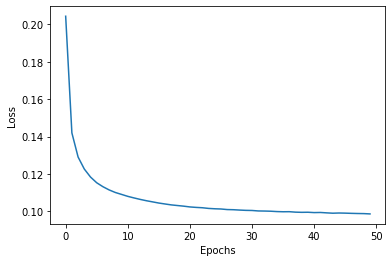

In [14]:
plt.plot(range(max_epochs), loss.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

9. And finally, you can see the wonderful reconstructed images from the noisy input images

input_features.shape :  (10000, 28, 28, 1)
Ex1 (10000, 28, 28, 32)
Ex2 (10000, 14, 14, 32)
Ex3 (10000, 14, 14, 32)
Ex4 (10000, 7, 7, 32)
Ex5 (10000, 7, 7, 16)
Ex6 (10000, 4, 4, 16)
encoded.shape :  (10000, 4, 4, 16)
dx1 (10000, 4, 4, 16)
dx2 (10000, 8, 8, 16)
dx3 (10000, 8, 8, 32)
dx4 (10000, 16, 16, 32)
dx5 (10000, 14, 14, 32)
dx6 (10000, 28, 28, 32)
dx7 (10000, 28, 28, 1)
reconstructed.shape :  (10000, 28, 28, 1)
input_features.shape :  (10000, 28, 28, 1)
Ex1 (10000, 28, 28, 32)
Ex2 (10000, 14, 14, 32)
Ex3 (10000, 14, 14, 32)
Ex4 (10000, 7, 7, 32)
Ex5 (10000, 7, 7, 16)
Ex6 (10000, 4, 4, 16)
encoded.shape :  (10000, 4, 4, 16)
dx1 (10000, 4, 4, 16)
dx2 (10000, 8, 8, 16)
dx3 (10000, 8, 8, 32)
dx4 (10000, 16, 16, 32)
dx5 (10000, 14, 14, 32)
dx6 (10000, 28, 28, 32)
dx7 (10000, 28, 28, 1)
reconstructed.shape :  (10000, 28, 28, 1)
input_features.shape :  (10000, 28, 28, 1)
Ex1 (10000, 28, 28, 32)
Ex2 (10000, 14, 14, 32)
Ex3 (10000, 14, 14, 32)
Ex4 (10000, 7, 7, 32)
Ex5 (10000, 7, 7, 16)
Ex6

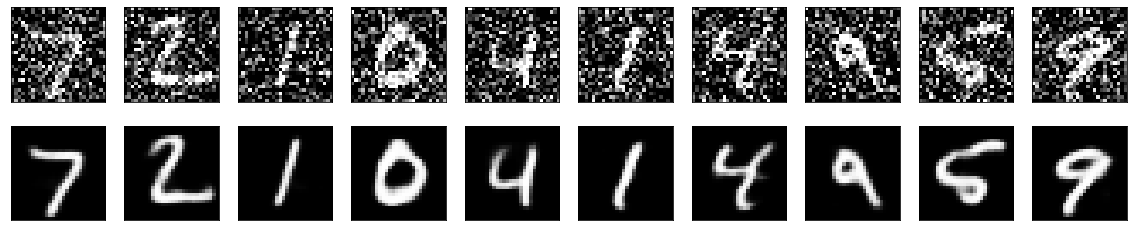

In [15]:
# you can see the original(top) and reconstructed(bottom) images
number = 10 # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test_noisy[index].reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(x_test_noisy)[index].numpy().reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Keras autoencoder example - sentence vectors